In [1]:
from hossam import *
from pandas import DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error)

from sklearn.ensemble import RandomForestRegressor

import shap

In [2]:
origin=load_data('restaurant_sales_preprocessed')
origin.set_index('date', inplace=True)
origin['holiday']=origin['holiday'].astype('category')
origin['weekend']=origin['weekend'].astype('category')
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB


In [3]:
df=origin

yname='sales'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=52)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

In [4]:
%%time

rf=RandomForestRegressor(random_state=52, n_jobs=-1)

param_grid={
    'n_estimators':[300,500],
    'max_depth':[None, 10],
    'min_samples_leaf':[5,10],
    'max_features':['sqrt', 1.0]
}

gs=GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

gs.fit(x_train, y_train)

best_model=gs.best_estimator_
best_model

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 516 ms
Wall time: 7.38 s


,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
from 성능평가함수 import *

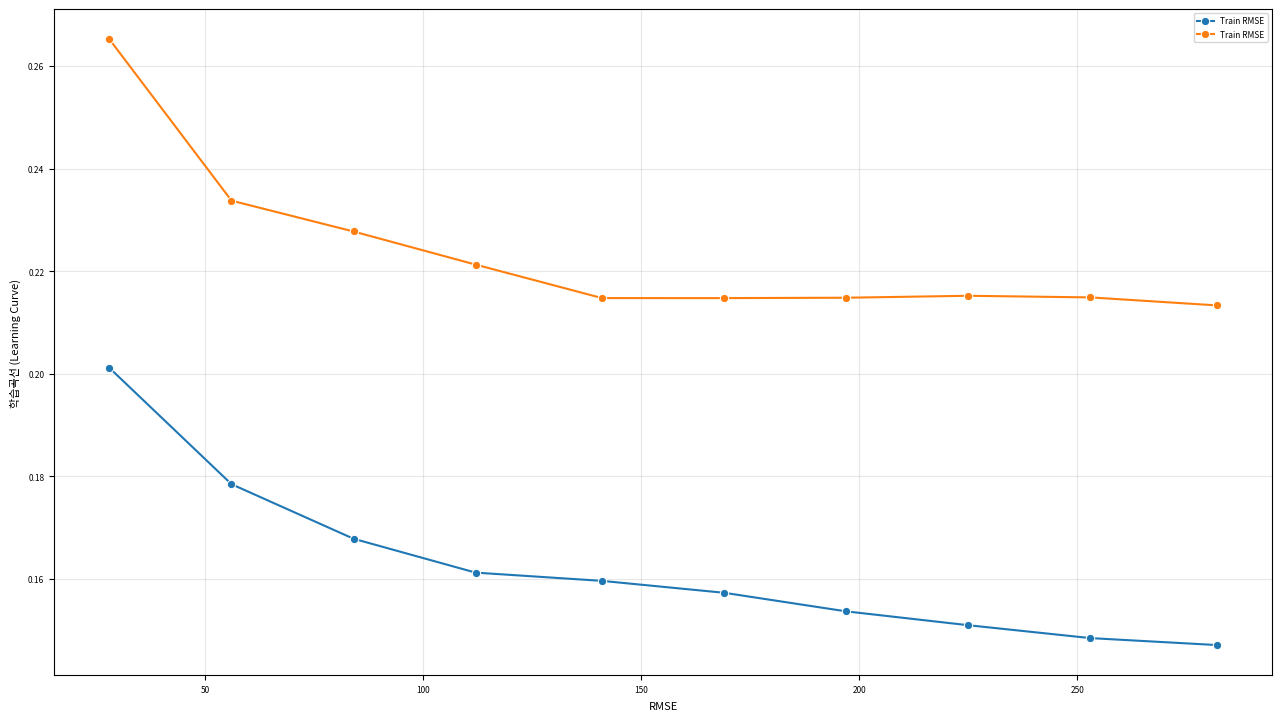

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
RandomForestRegressor,0.859,0.111,0.021,0.144,0.007,-0.009,0.147,0.213,0.015,0.689,0.072,⚠️ 과대적합 (variance 큼)


In [6]:
hs_get_score_cv(best_model, x_train, y_train, x, y)

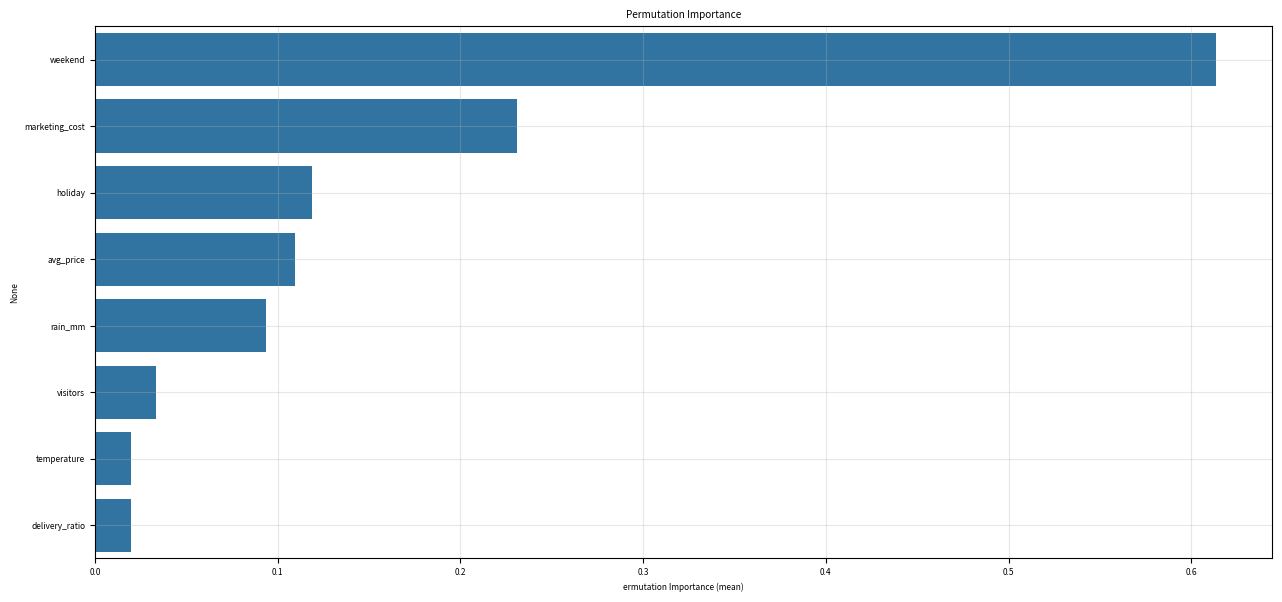

,importance_mean,importance_std
weekend,0.613,0.064
marketing_cost,0.231,0.027
holiday,0.119,0.016
avg_price,0.109,0.014
rain_mm,0.094,0.009
visitors,0.033,0.004
temperature,0.020,0.002
delivery_ratio,0.020,0.002


In [7]:
feature_importance(best_model, x_train, y_train)

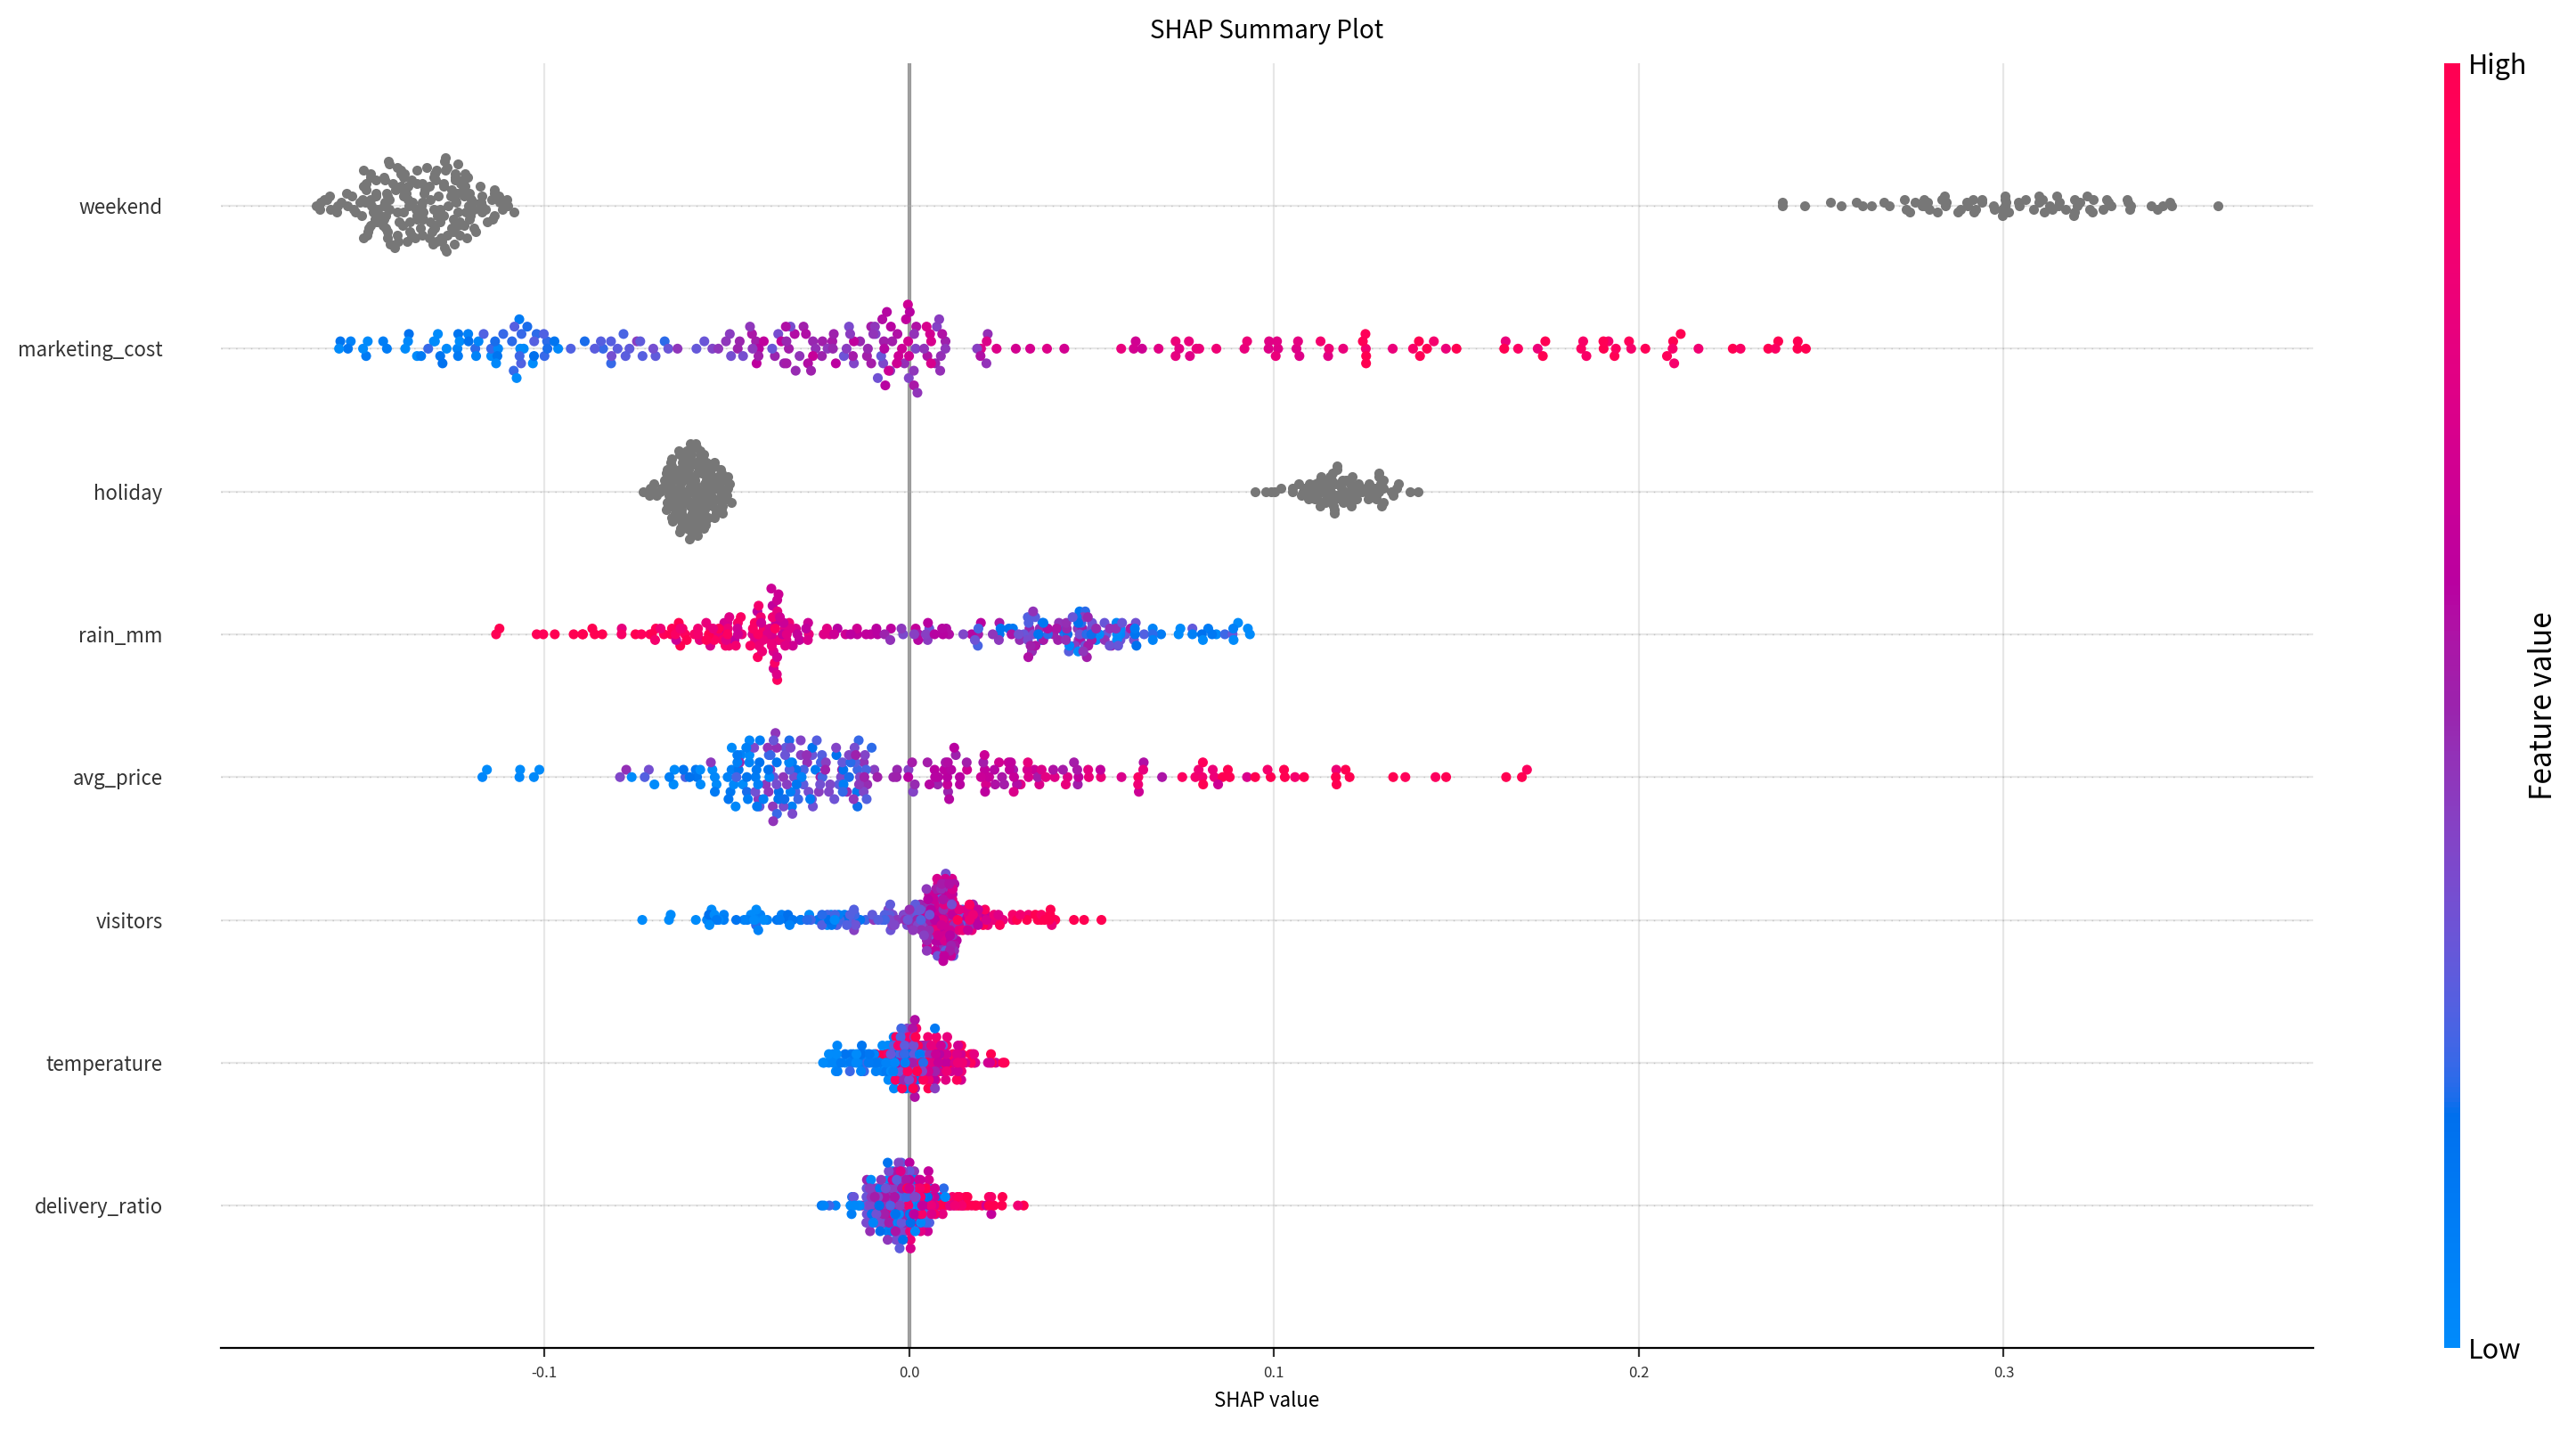

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,weekend,0.184,-0.004,0.200,음(-) 경향,1.088,variable,0.395,0.395,core
1,marketing_cost,0.081,0.001,0.104,양(+) 경향,1.277,variable,0.174,0.569,core
2,holiday,0.080,0.003,0.085,양(+) 경향,1.065,variable,0.171,0.740,core
3,rain_mm,0.046,-0.001,0.051,음(-) 경향,1.113,variable,0.098,0.838,secondary
4,avg_price,0.043,-0.002,0.054,음(-) 경향,1.252,variable,0.092,0.930,secondary
5,visitors,0.018,0.000,0.023,양(+) 경향,1.301,variable,0.038,0.969,secondary
6,temperature,0.008,0.000,0.010,양(+) 경향,1.291,variable,0.017,0.985,secondary
7,delivery_ratio,0.007,-0.000,0.009,음(-) 경향,1.328,variable,0.015,1.000,secondary


array([[ 0.01366157, -0.04865294, -0.00682275, -0.00855129, -0.04293852,
         0.00485115, -0.06237565, -0.13721416],
       [ 0.00531296,  0.08734606, -0.10821597, -0.00786912, -0.06816537,
         0.00306888, -0.06253319, -0.14253912],
       [-0.01564906, -0.03203023,  0.08419588,  0.00289335, -0.04069614,
        -0.02025376,  0.10970496,  0.29004481],
       [ 0.03225695,  0.02354357, -0.01133451, -0.00095103,  0.06209149,
        -0.00185498, -0.05164813, -0.1102291 ],
       [-0.03498917, -0.01167578, -0.00861744,  0.00689836, -0.04119851,
         0.00561855, -0.05633   , -0.13034683]])

In [8]:
summary_df, shap_values=hs_shap_analysis(best_model, x_train)
display(summary_df)
display(shap_values[:5])

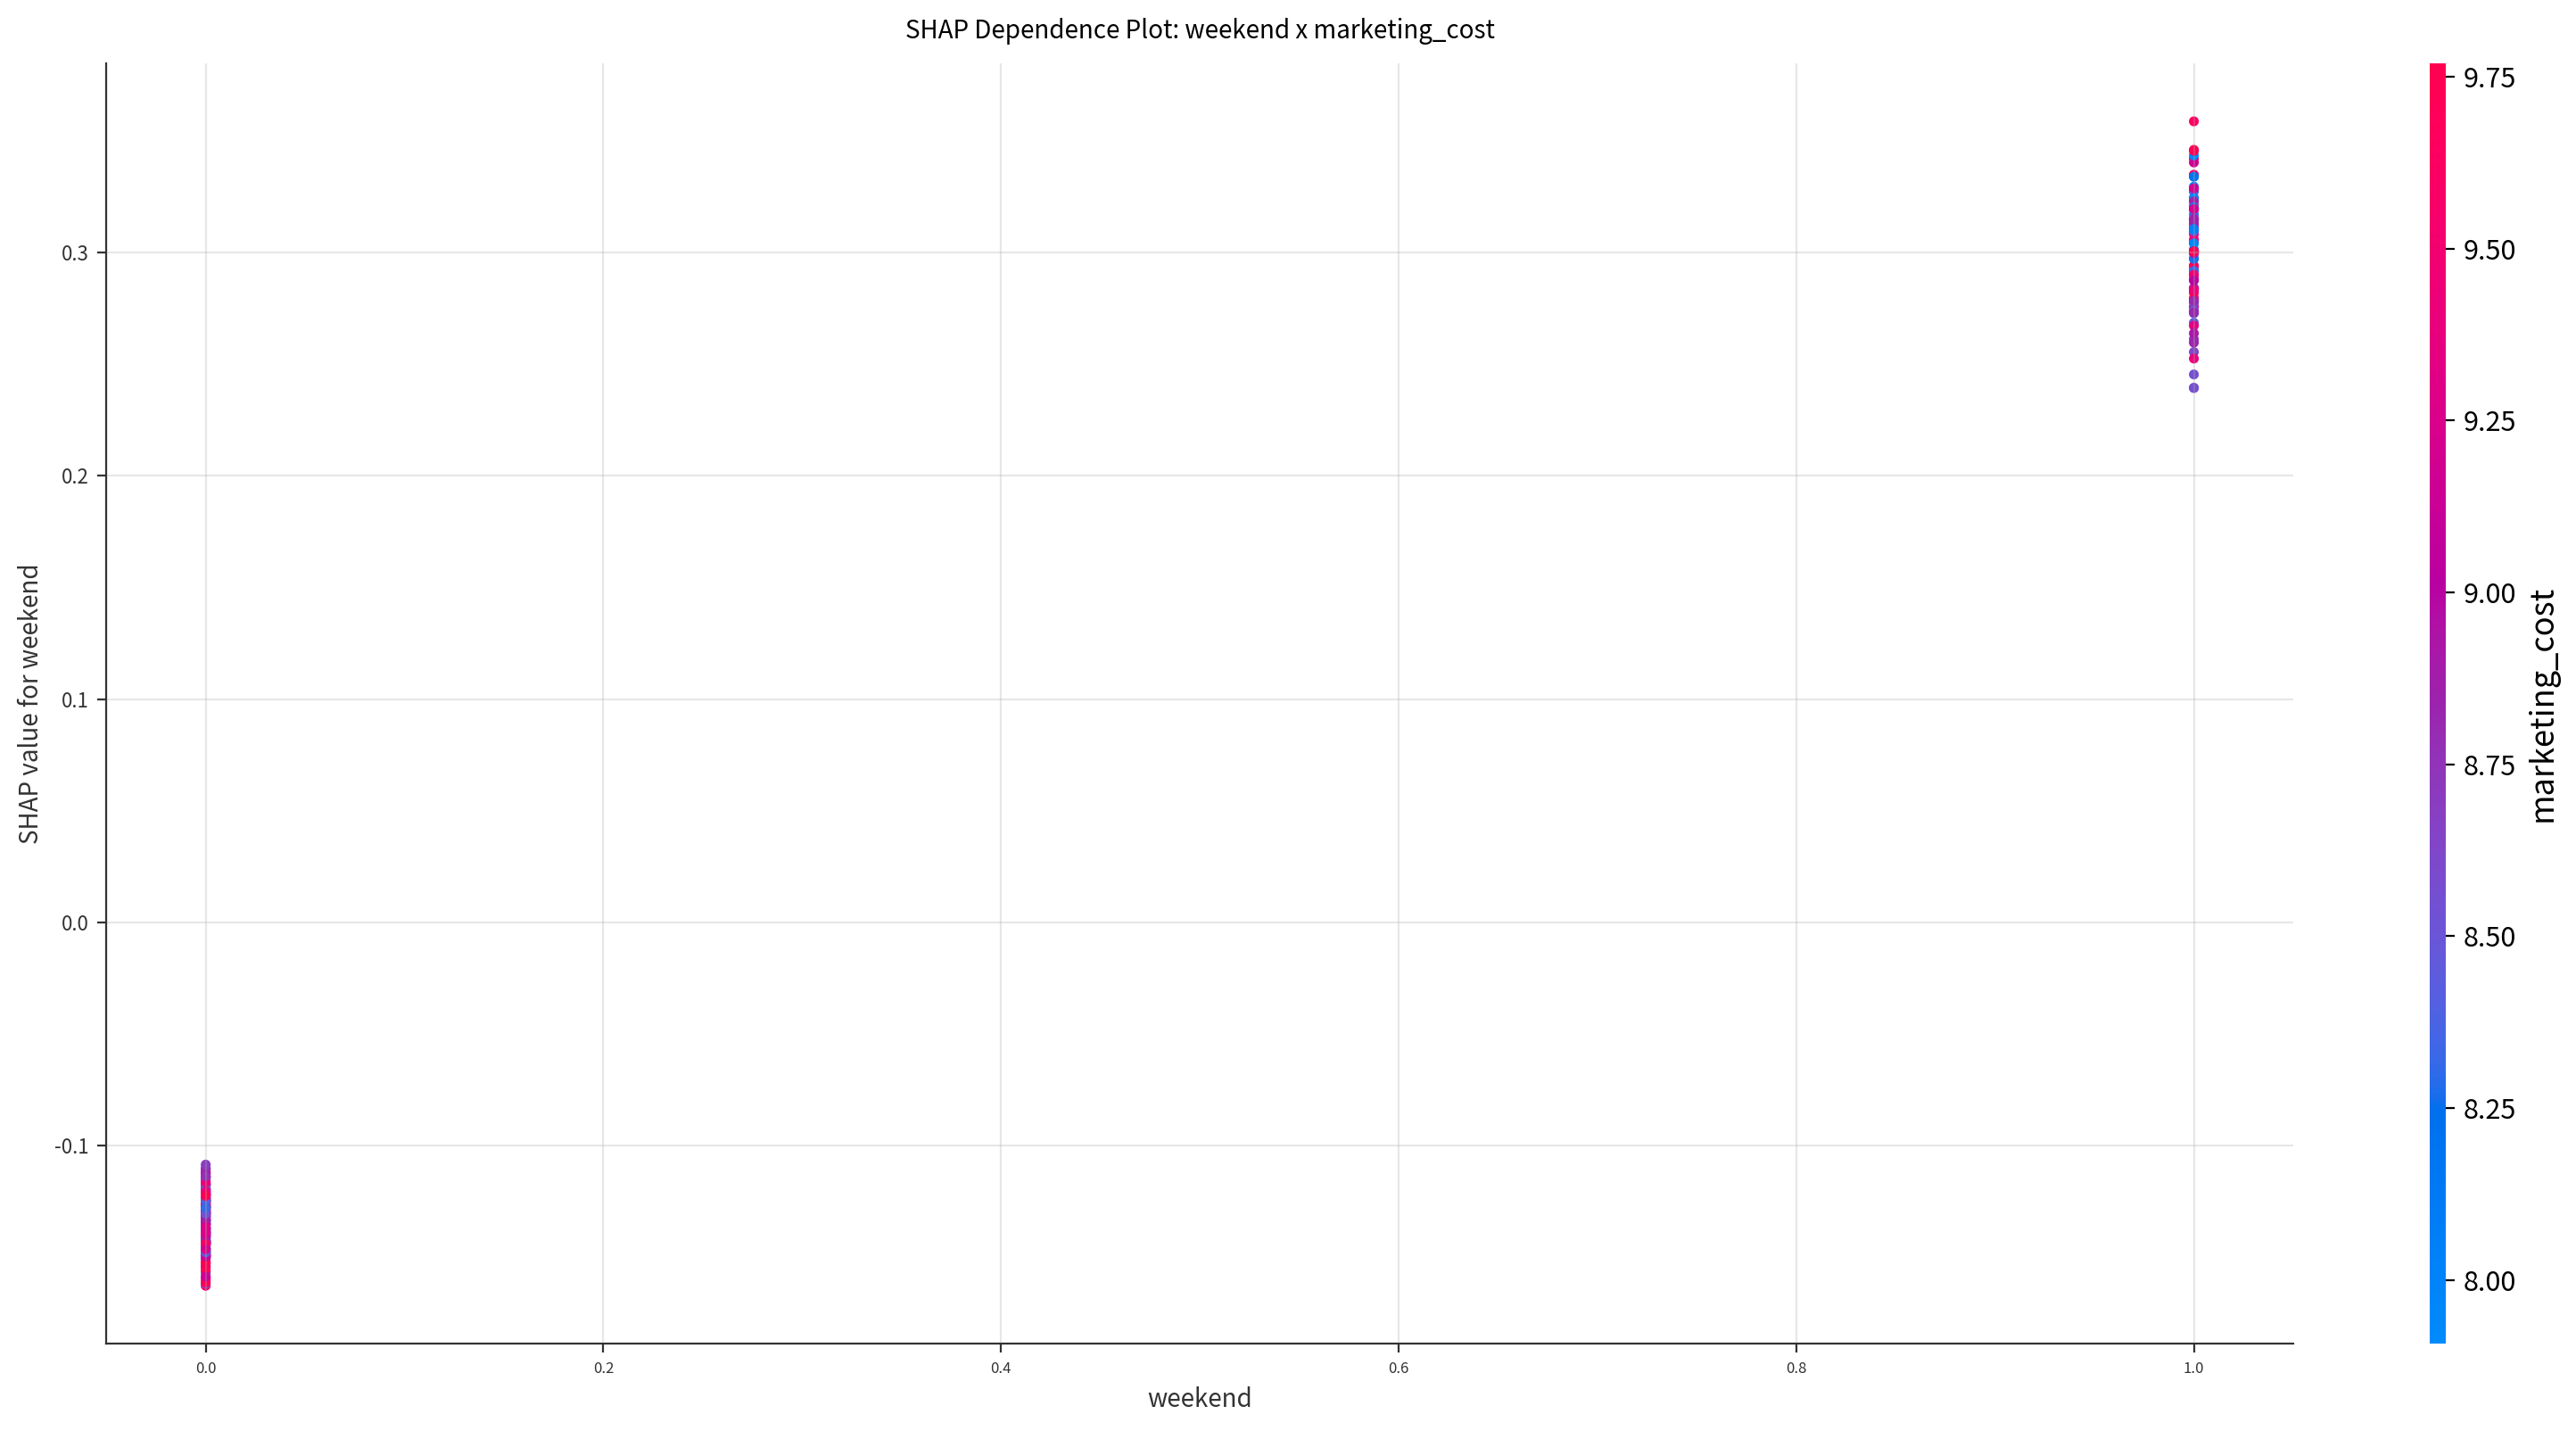

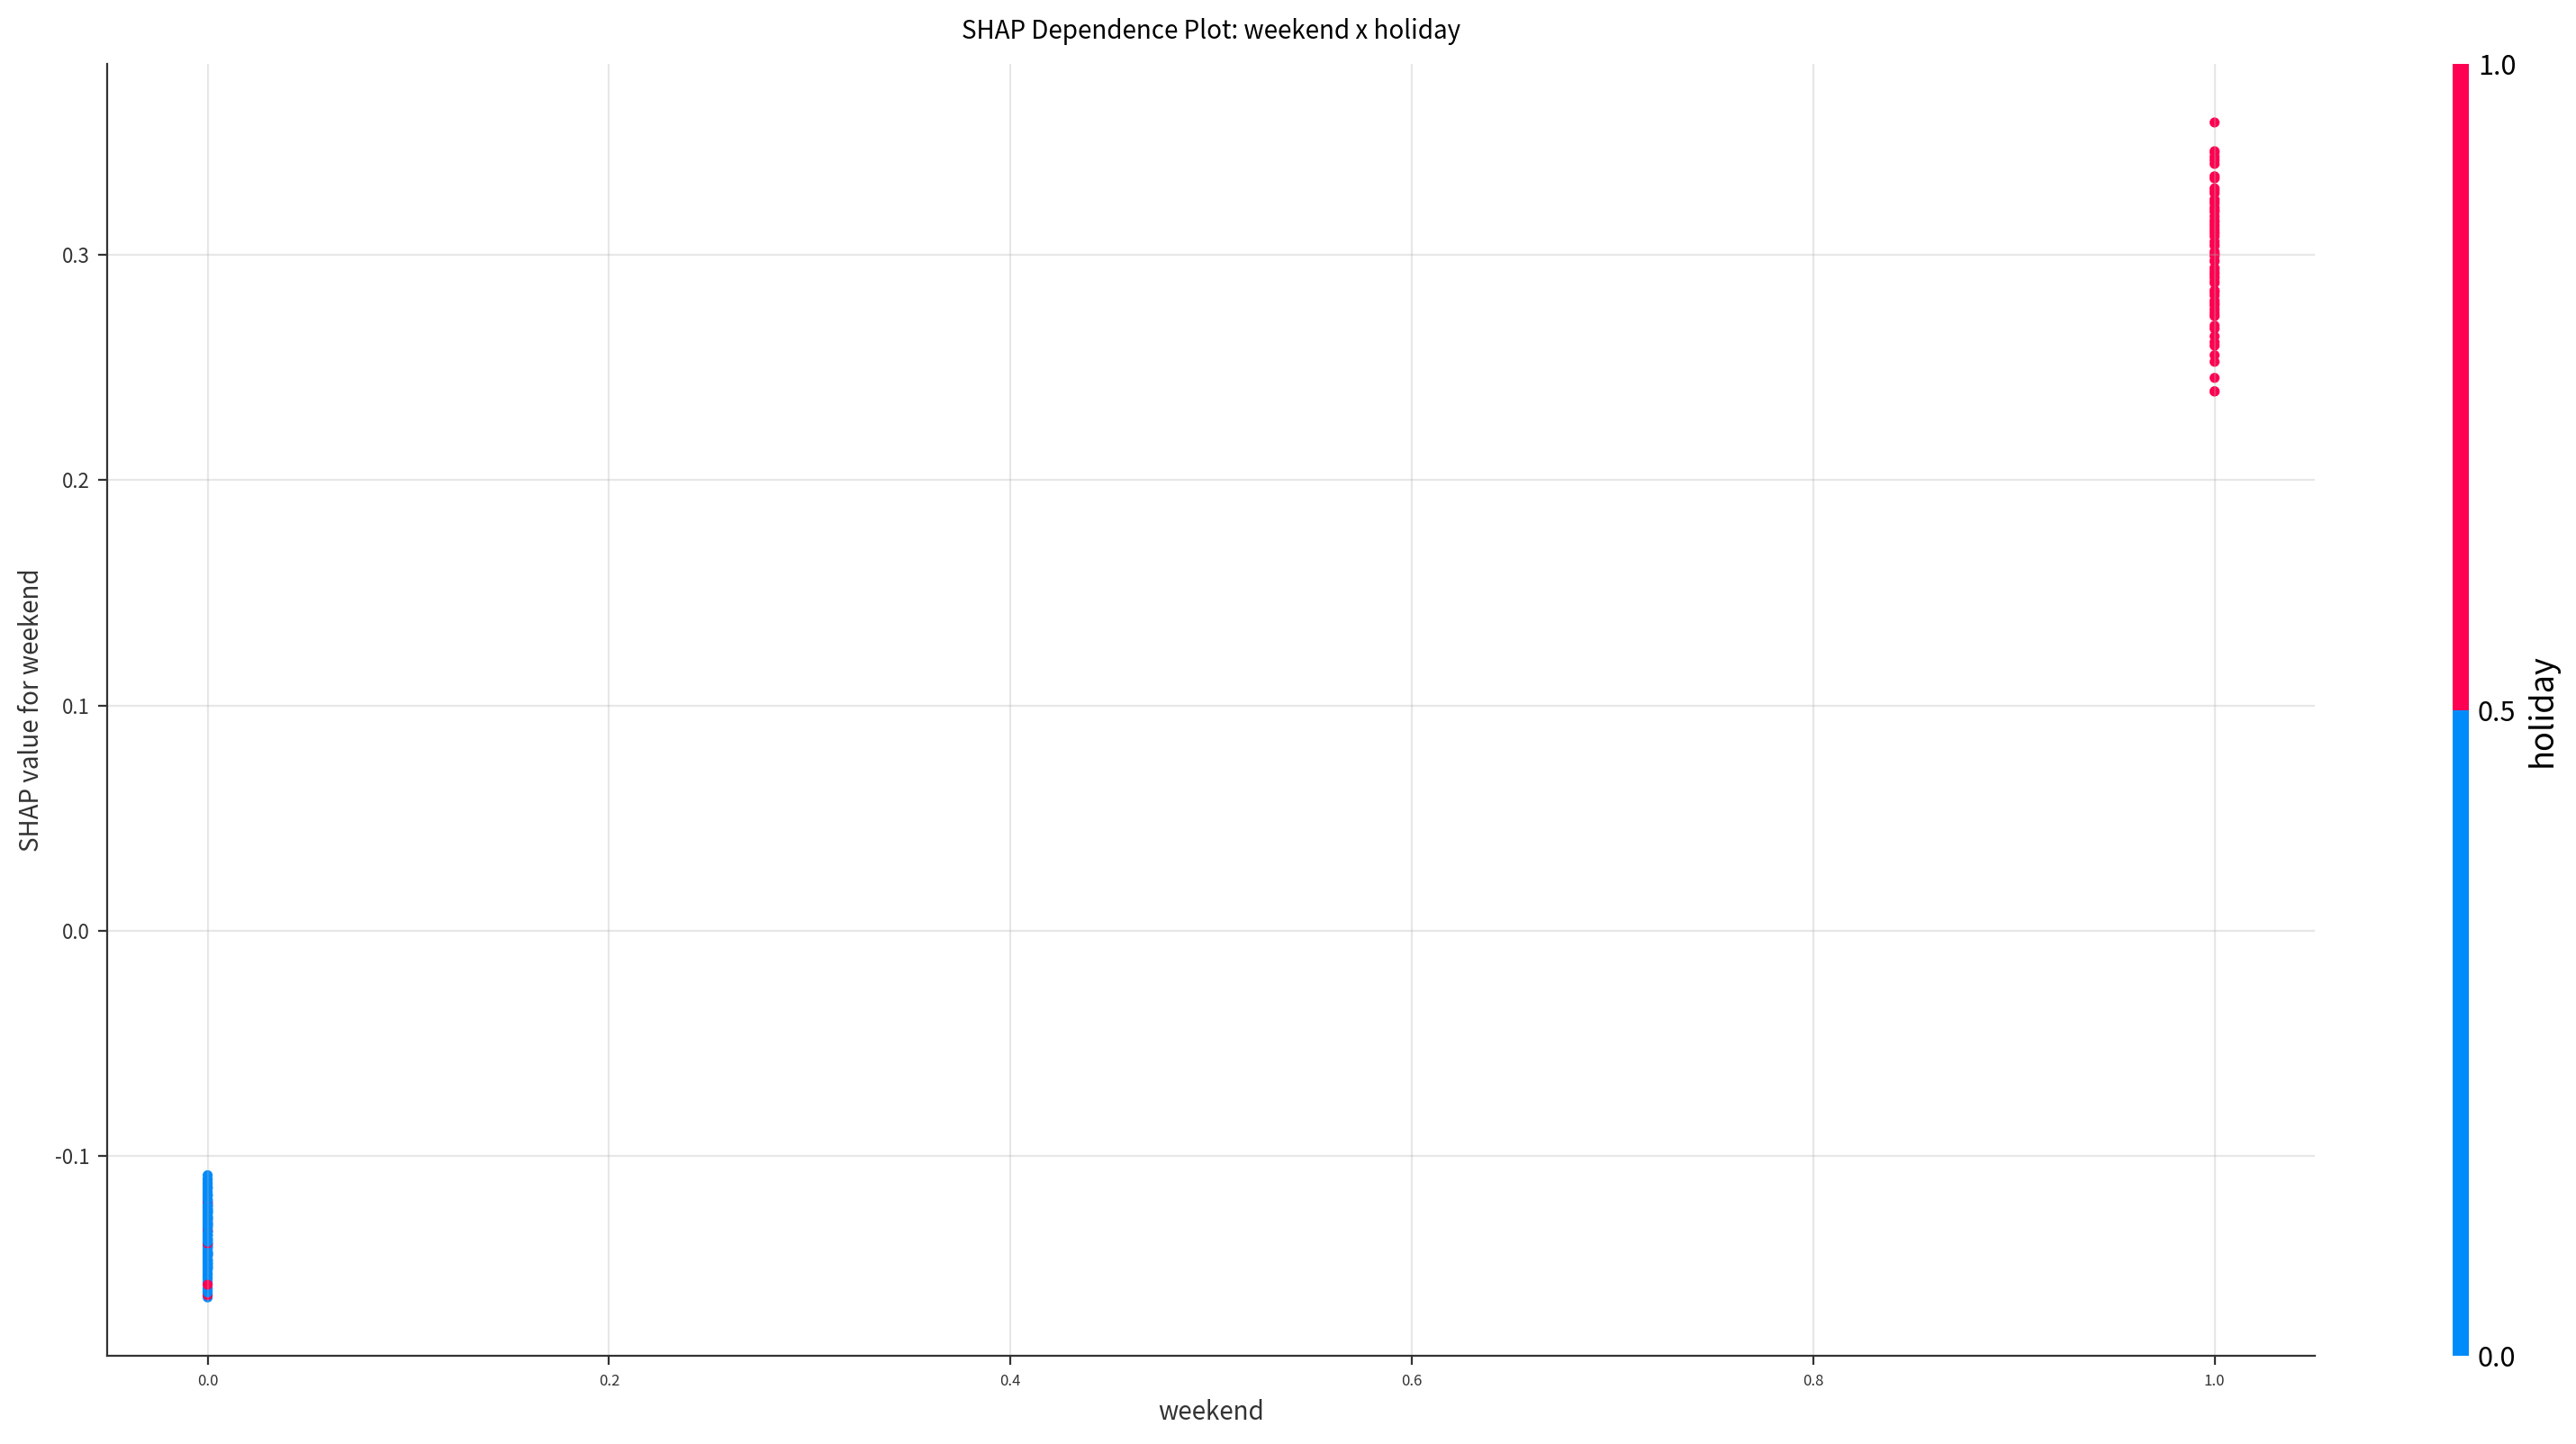

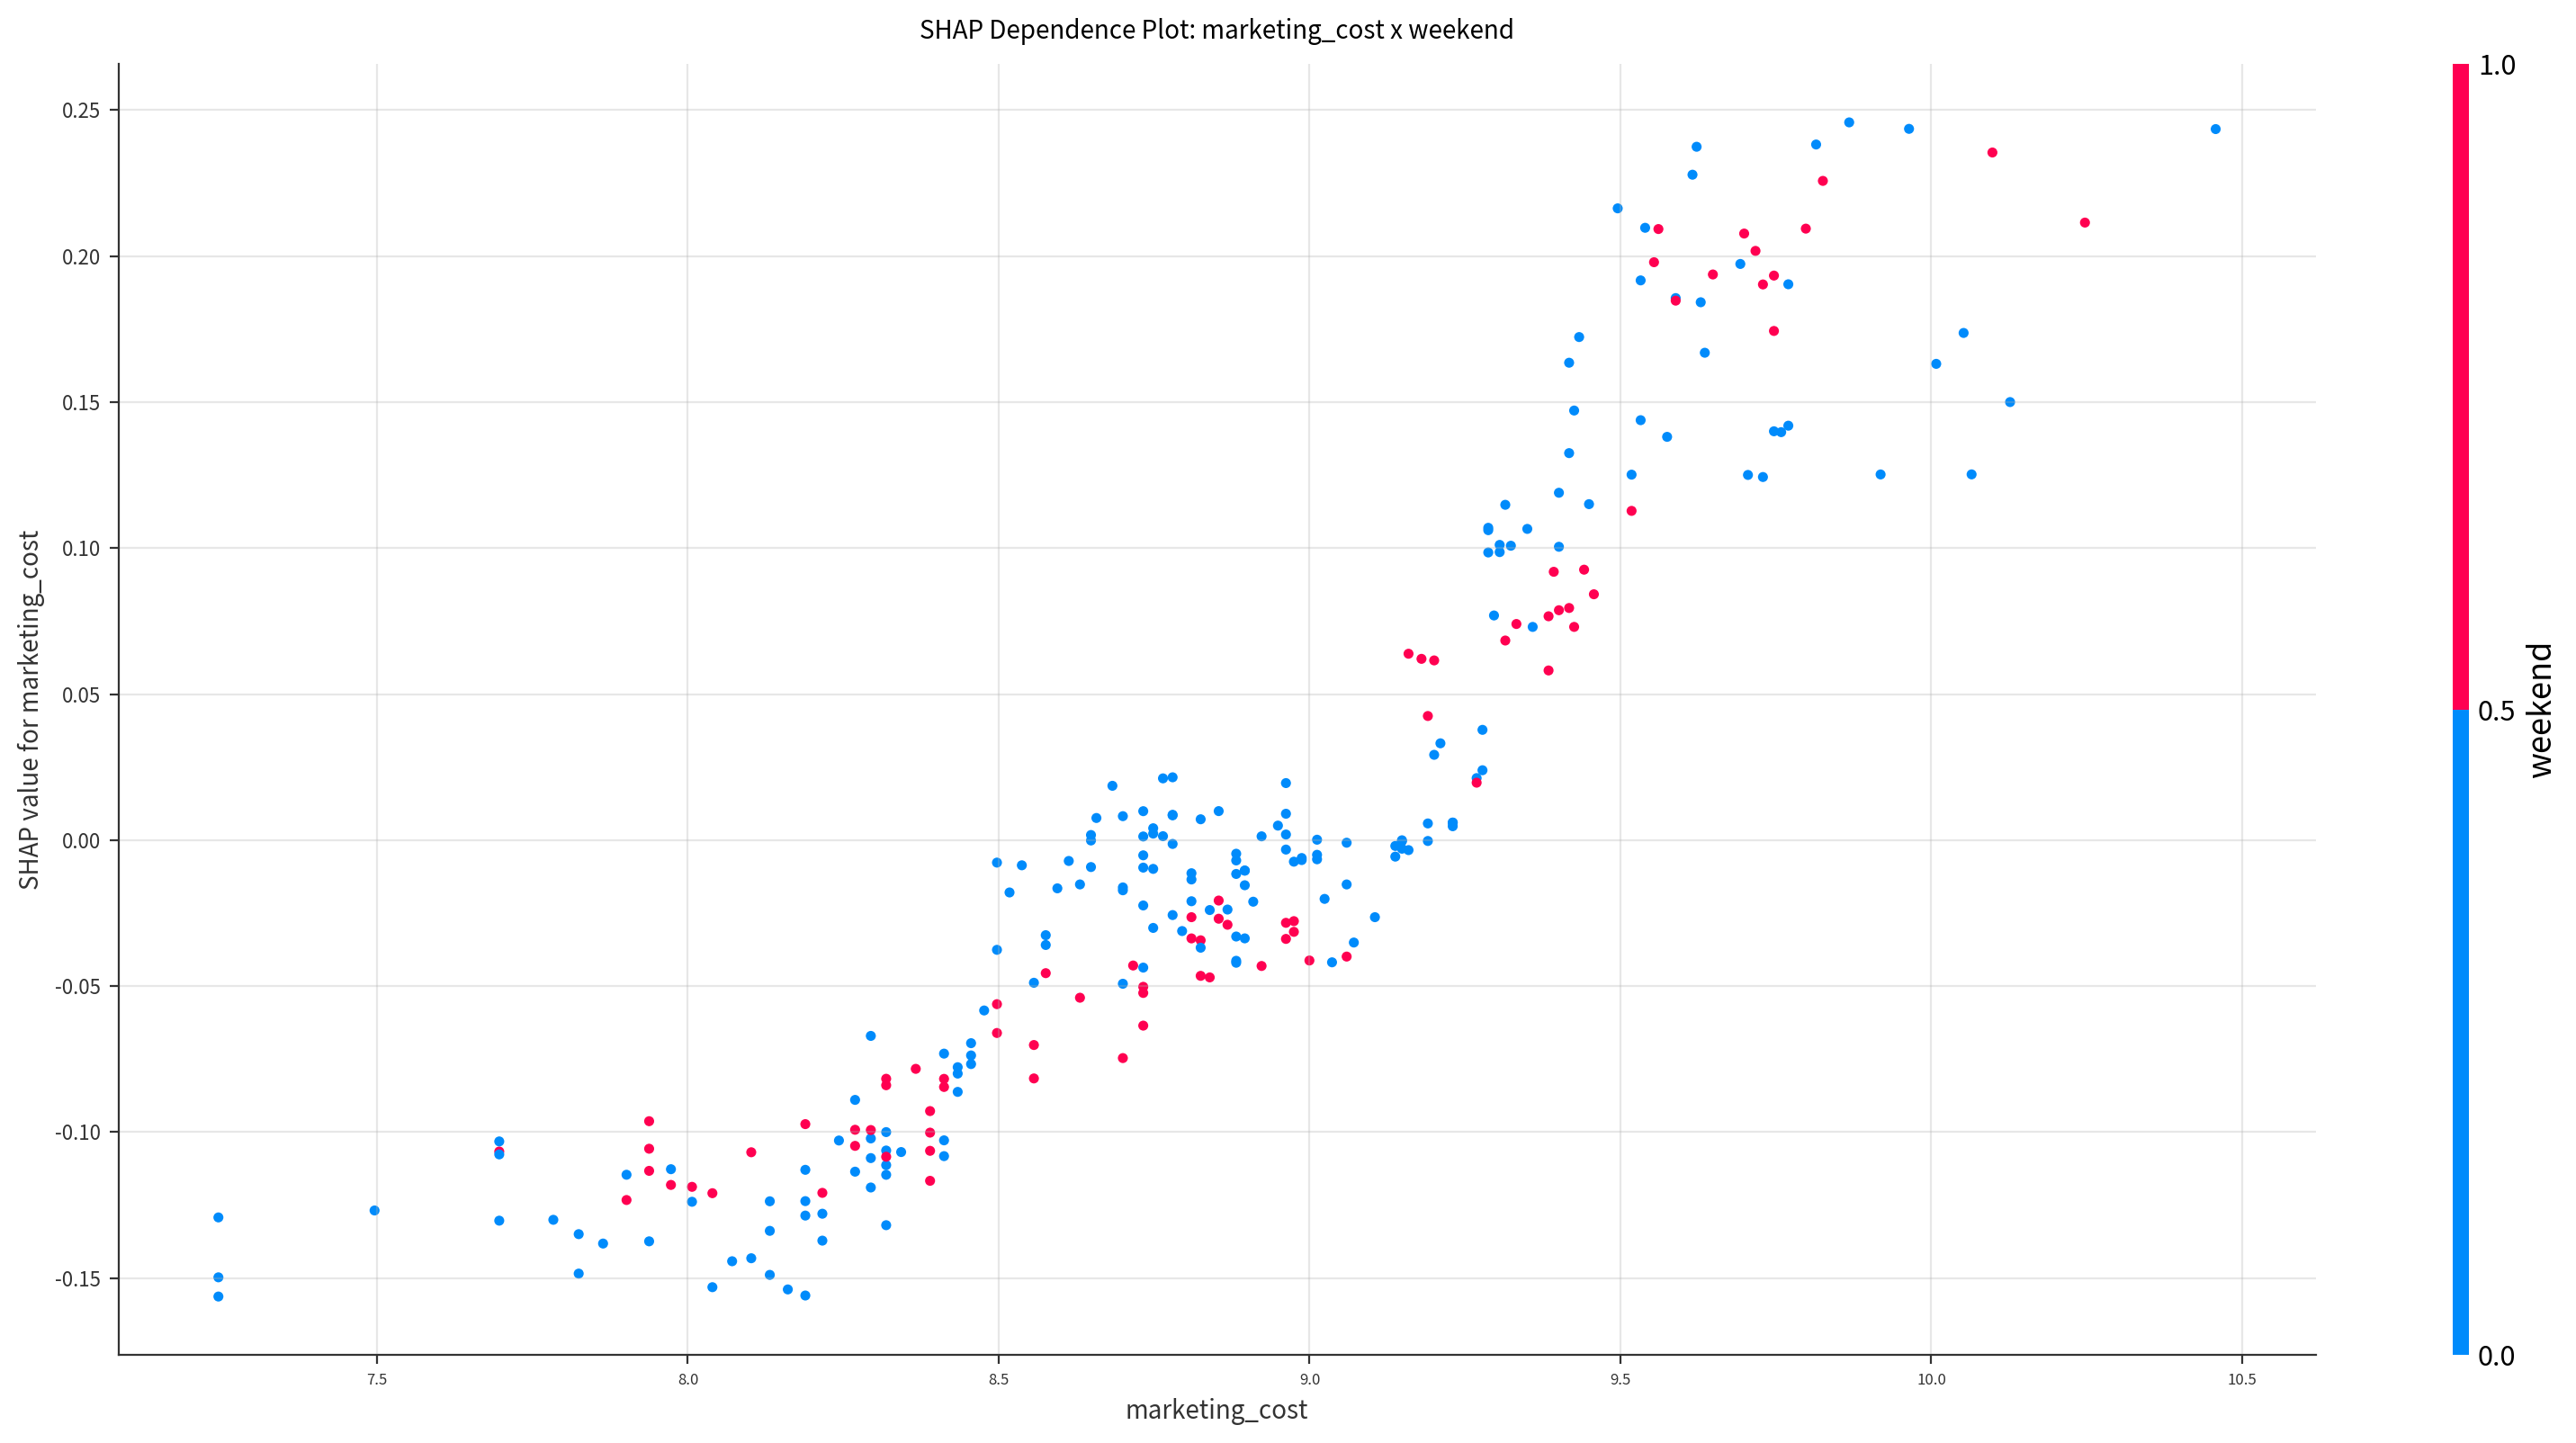

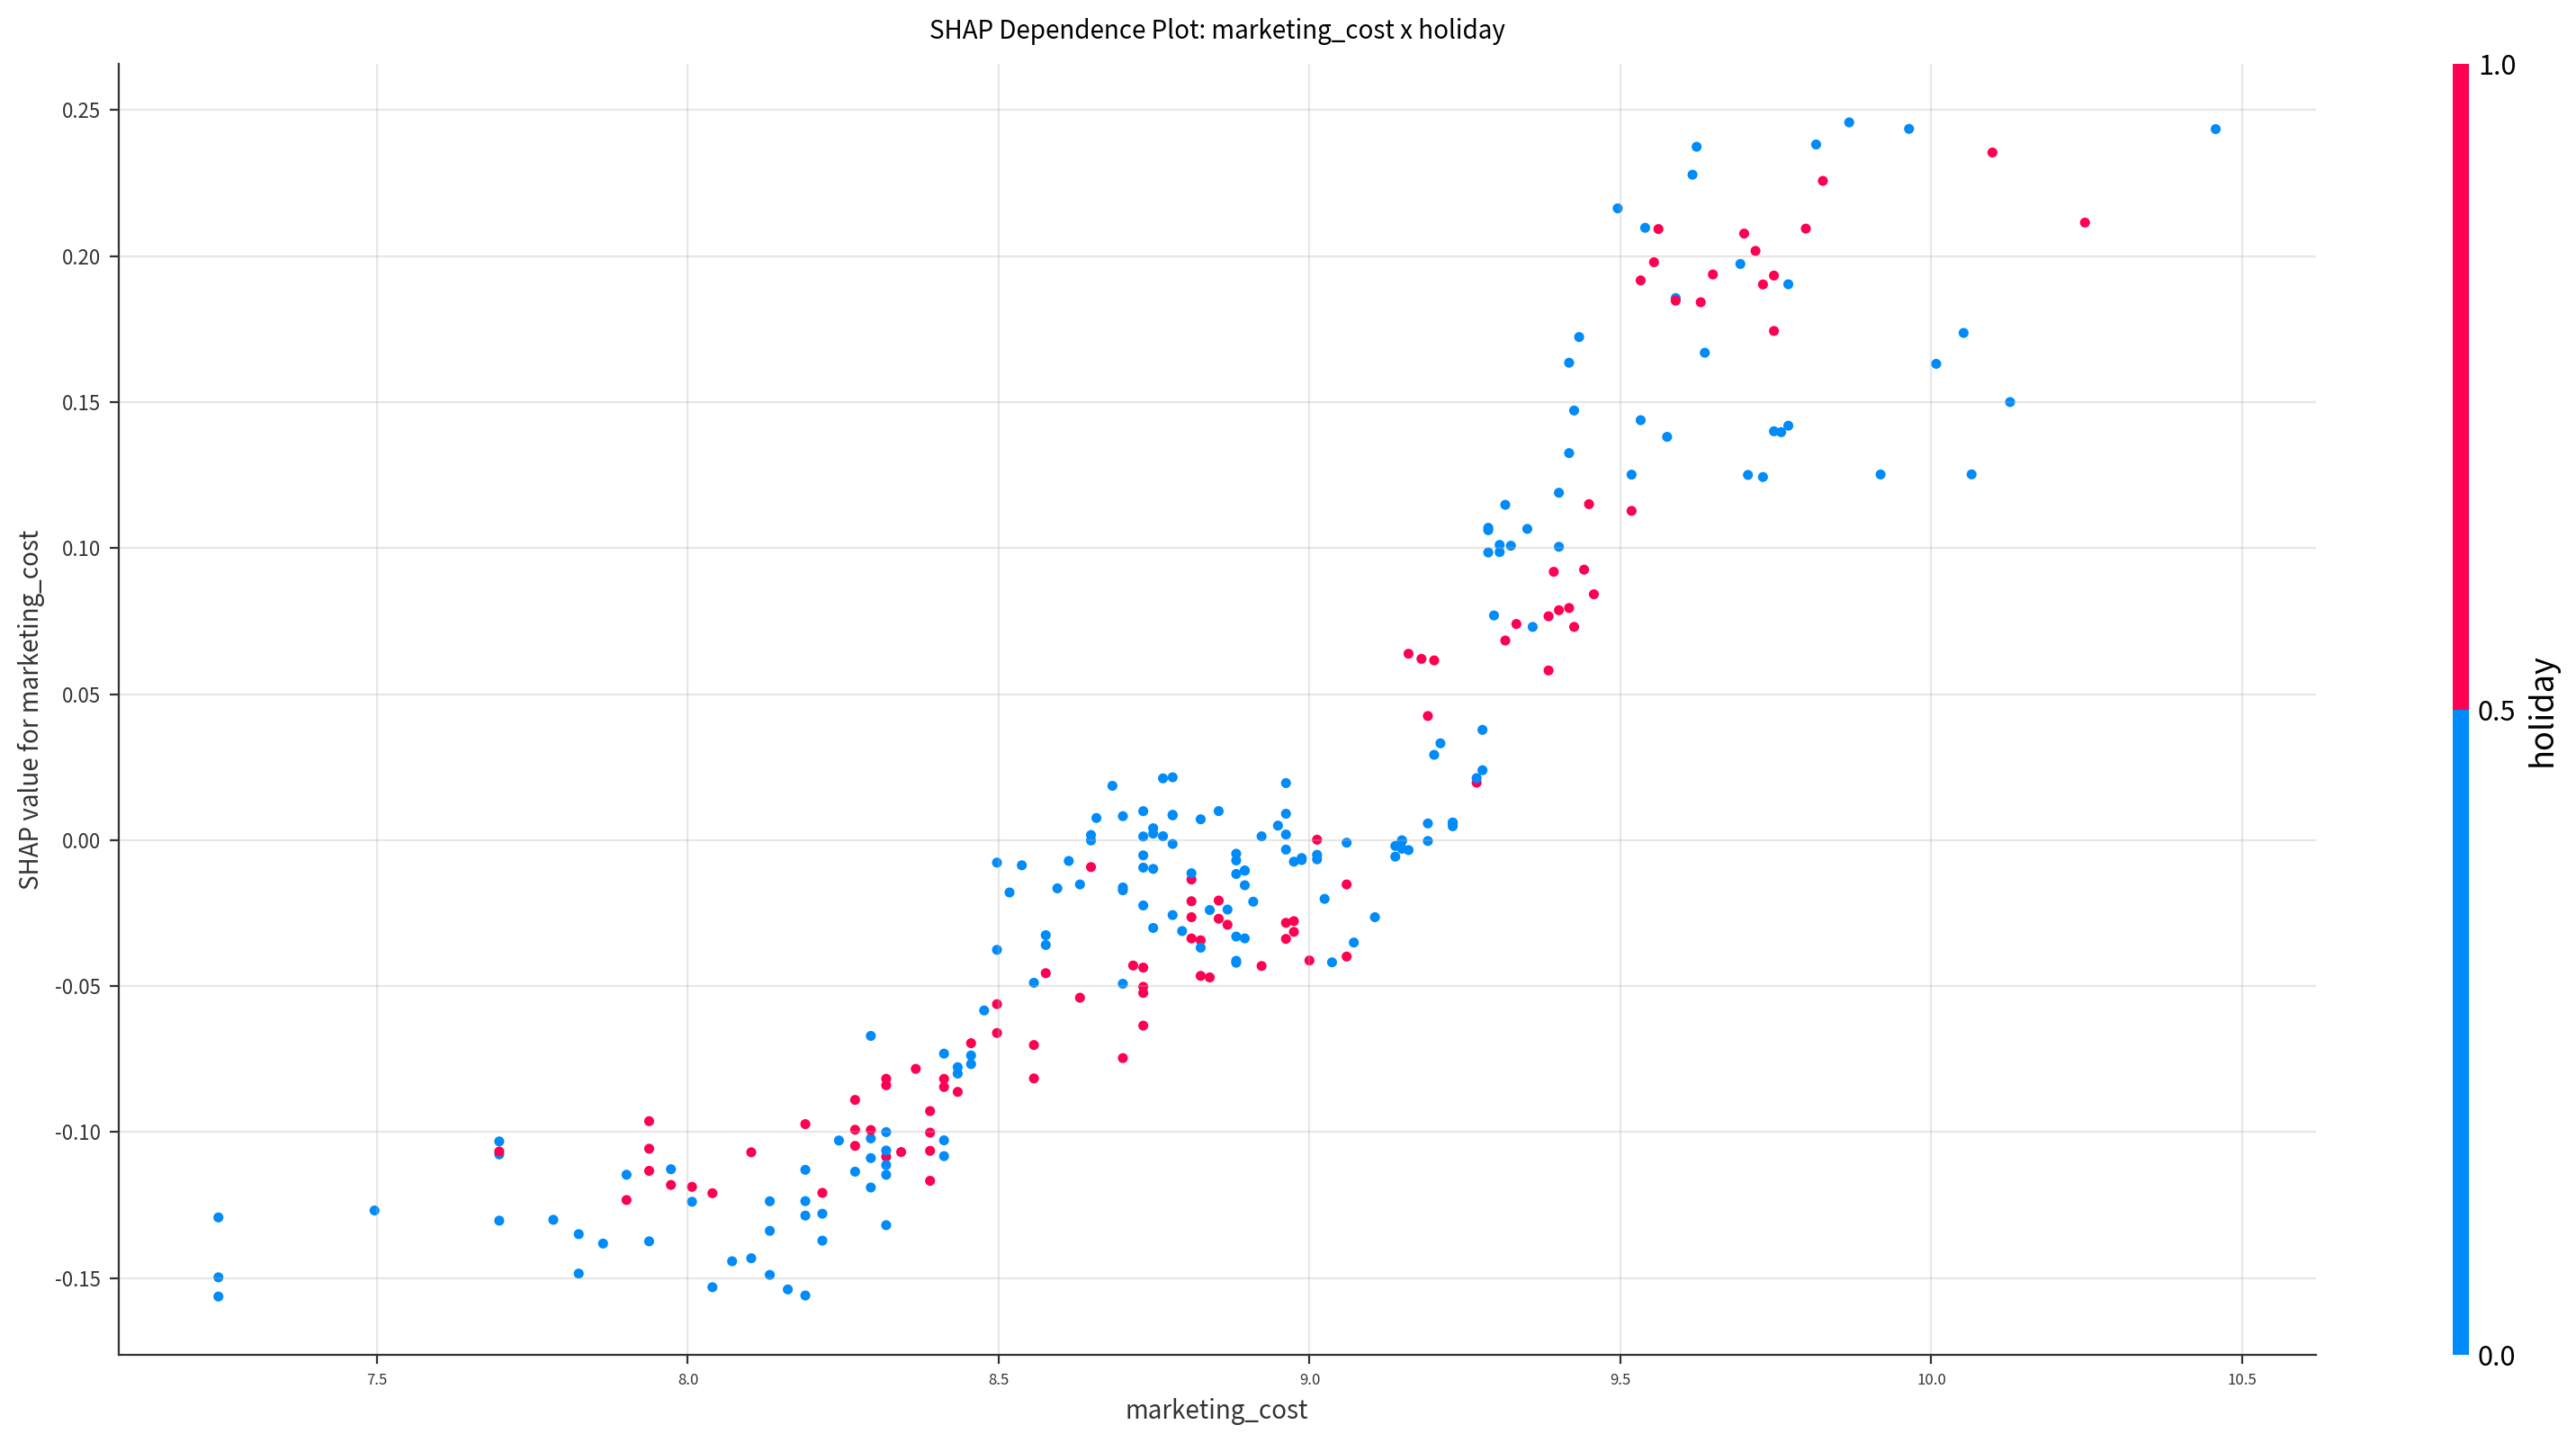

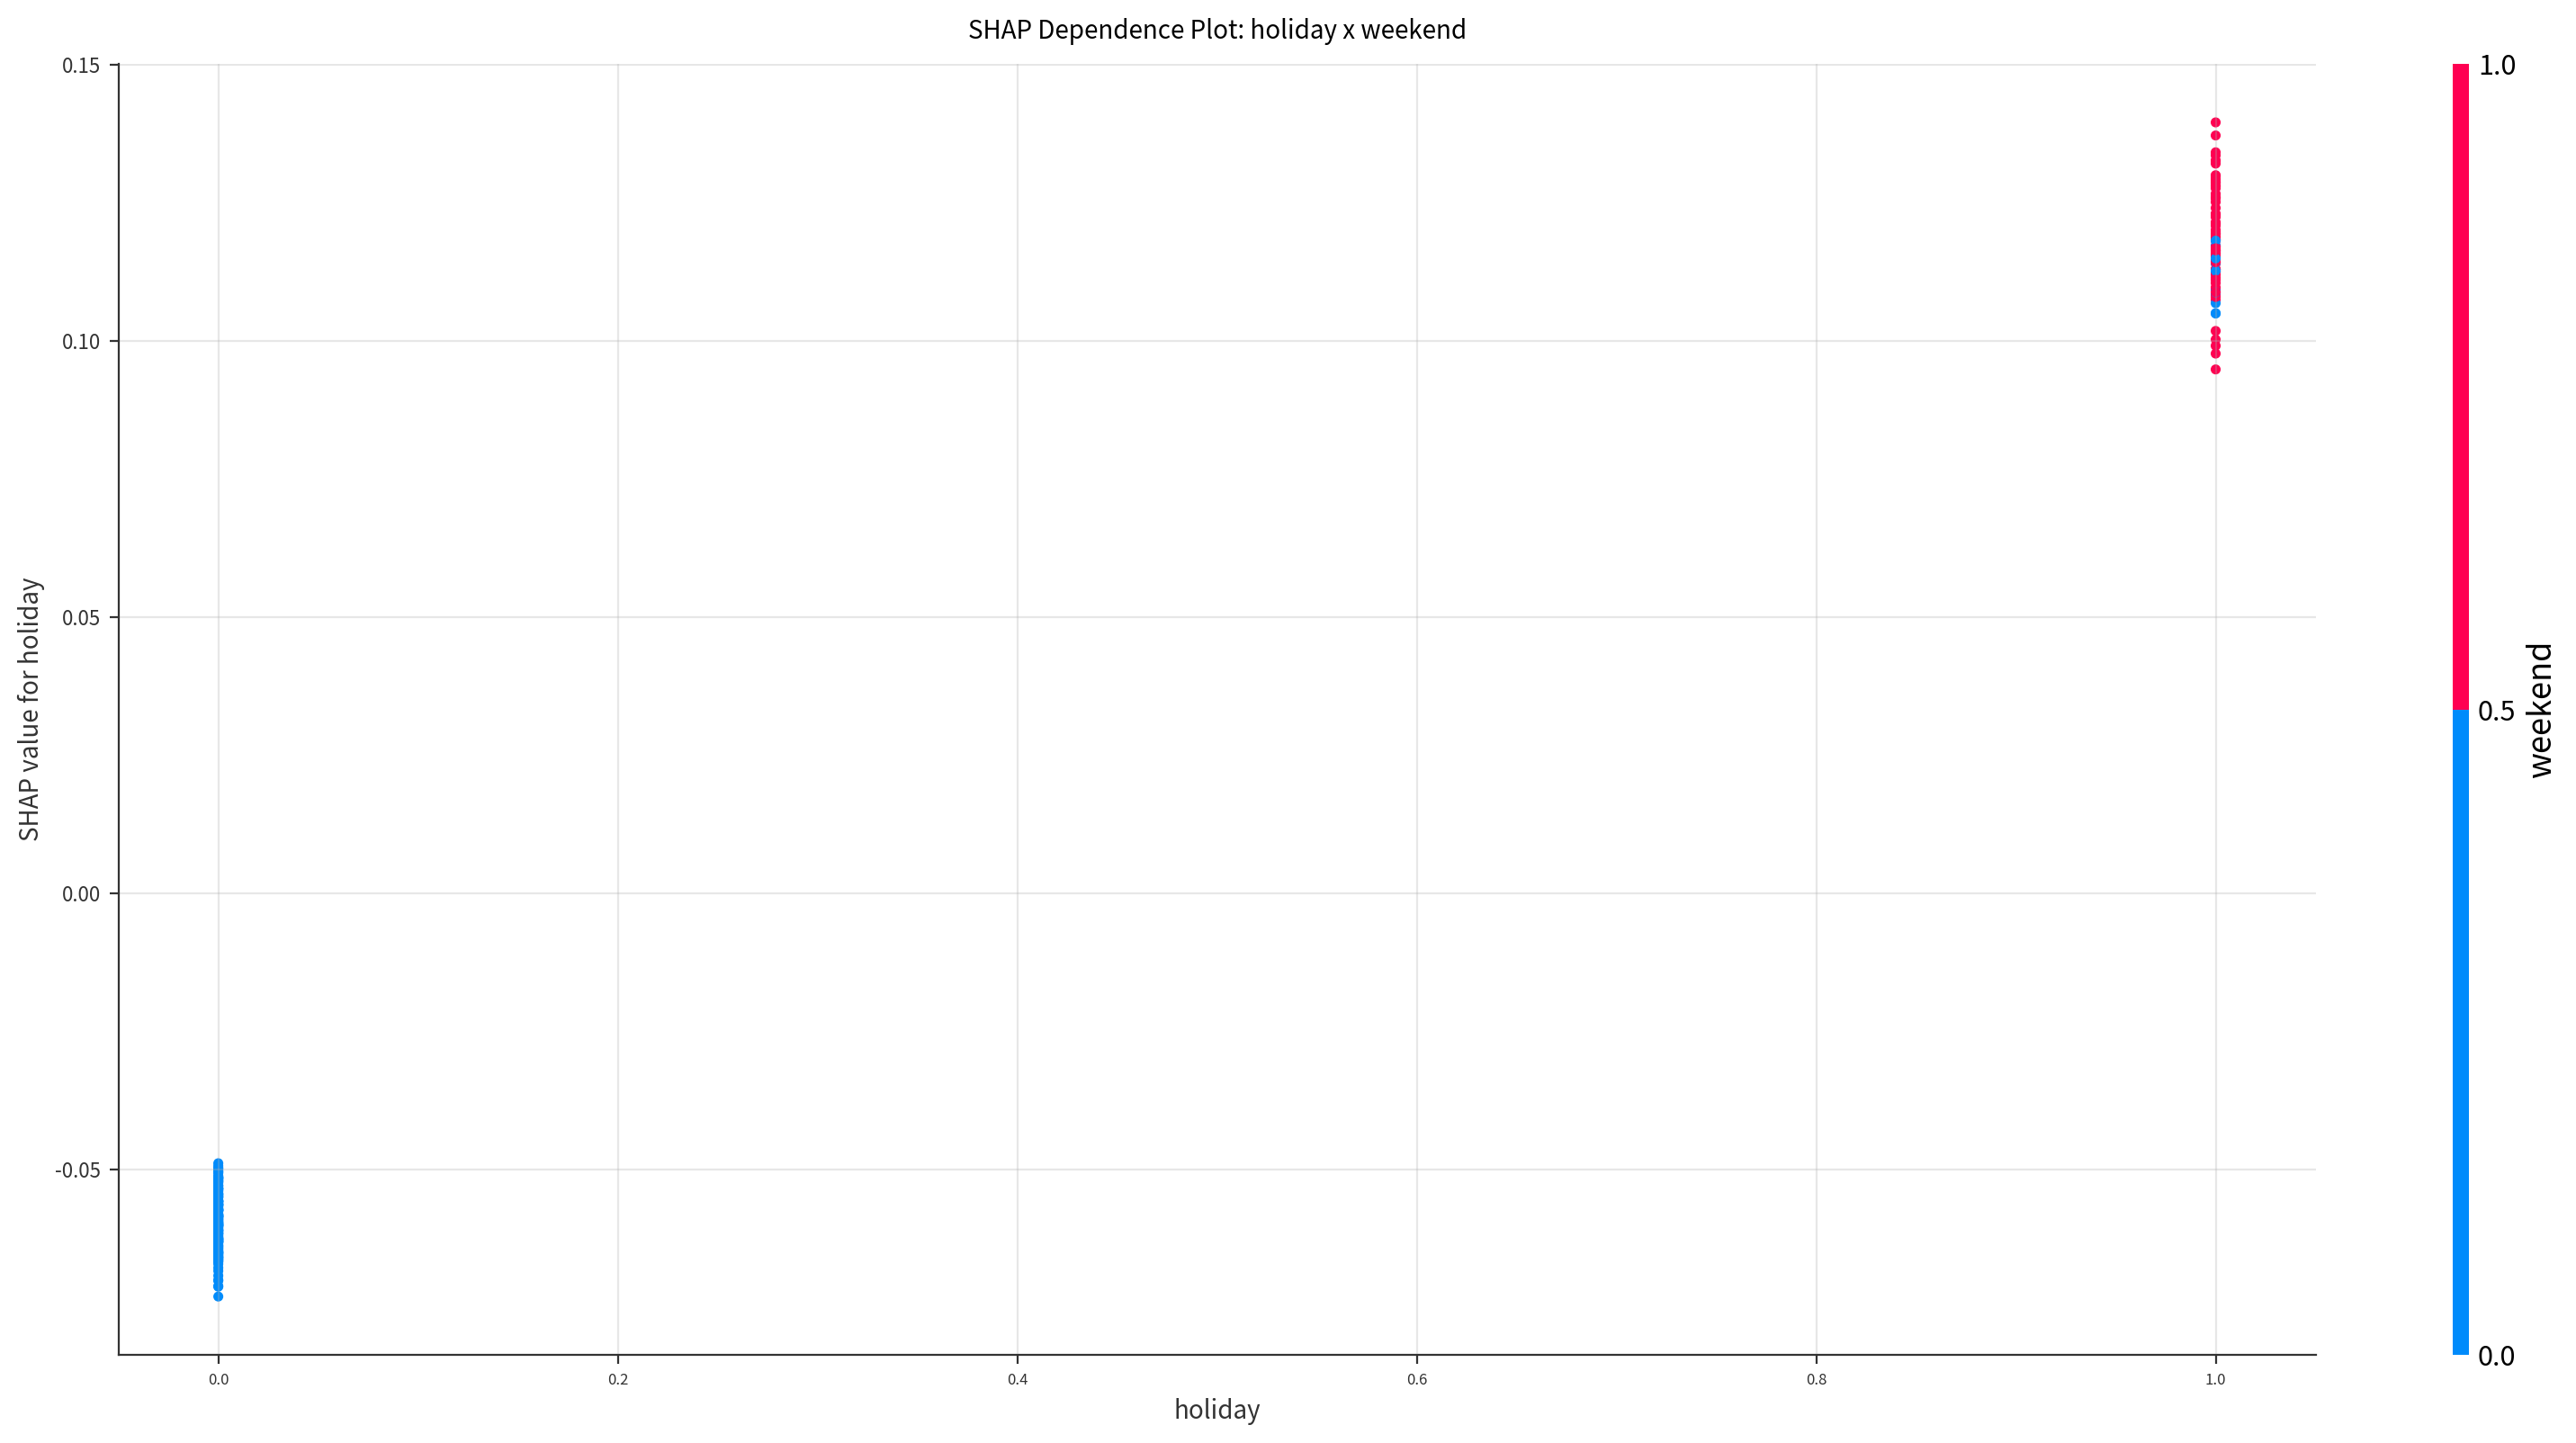

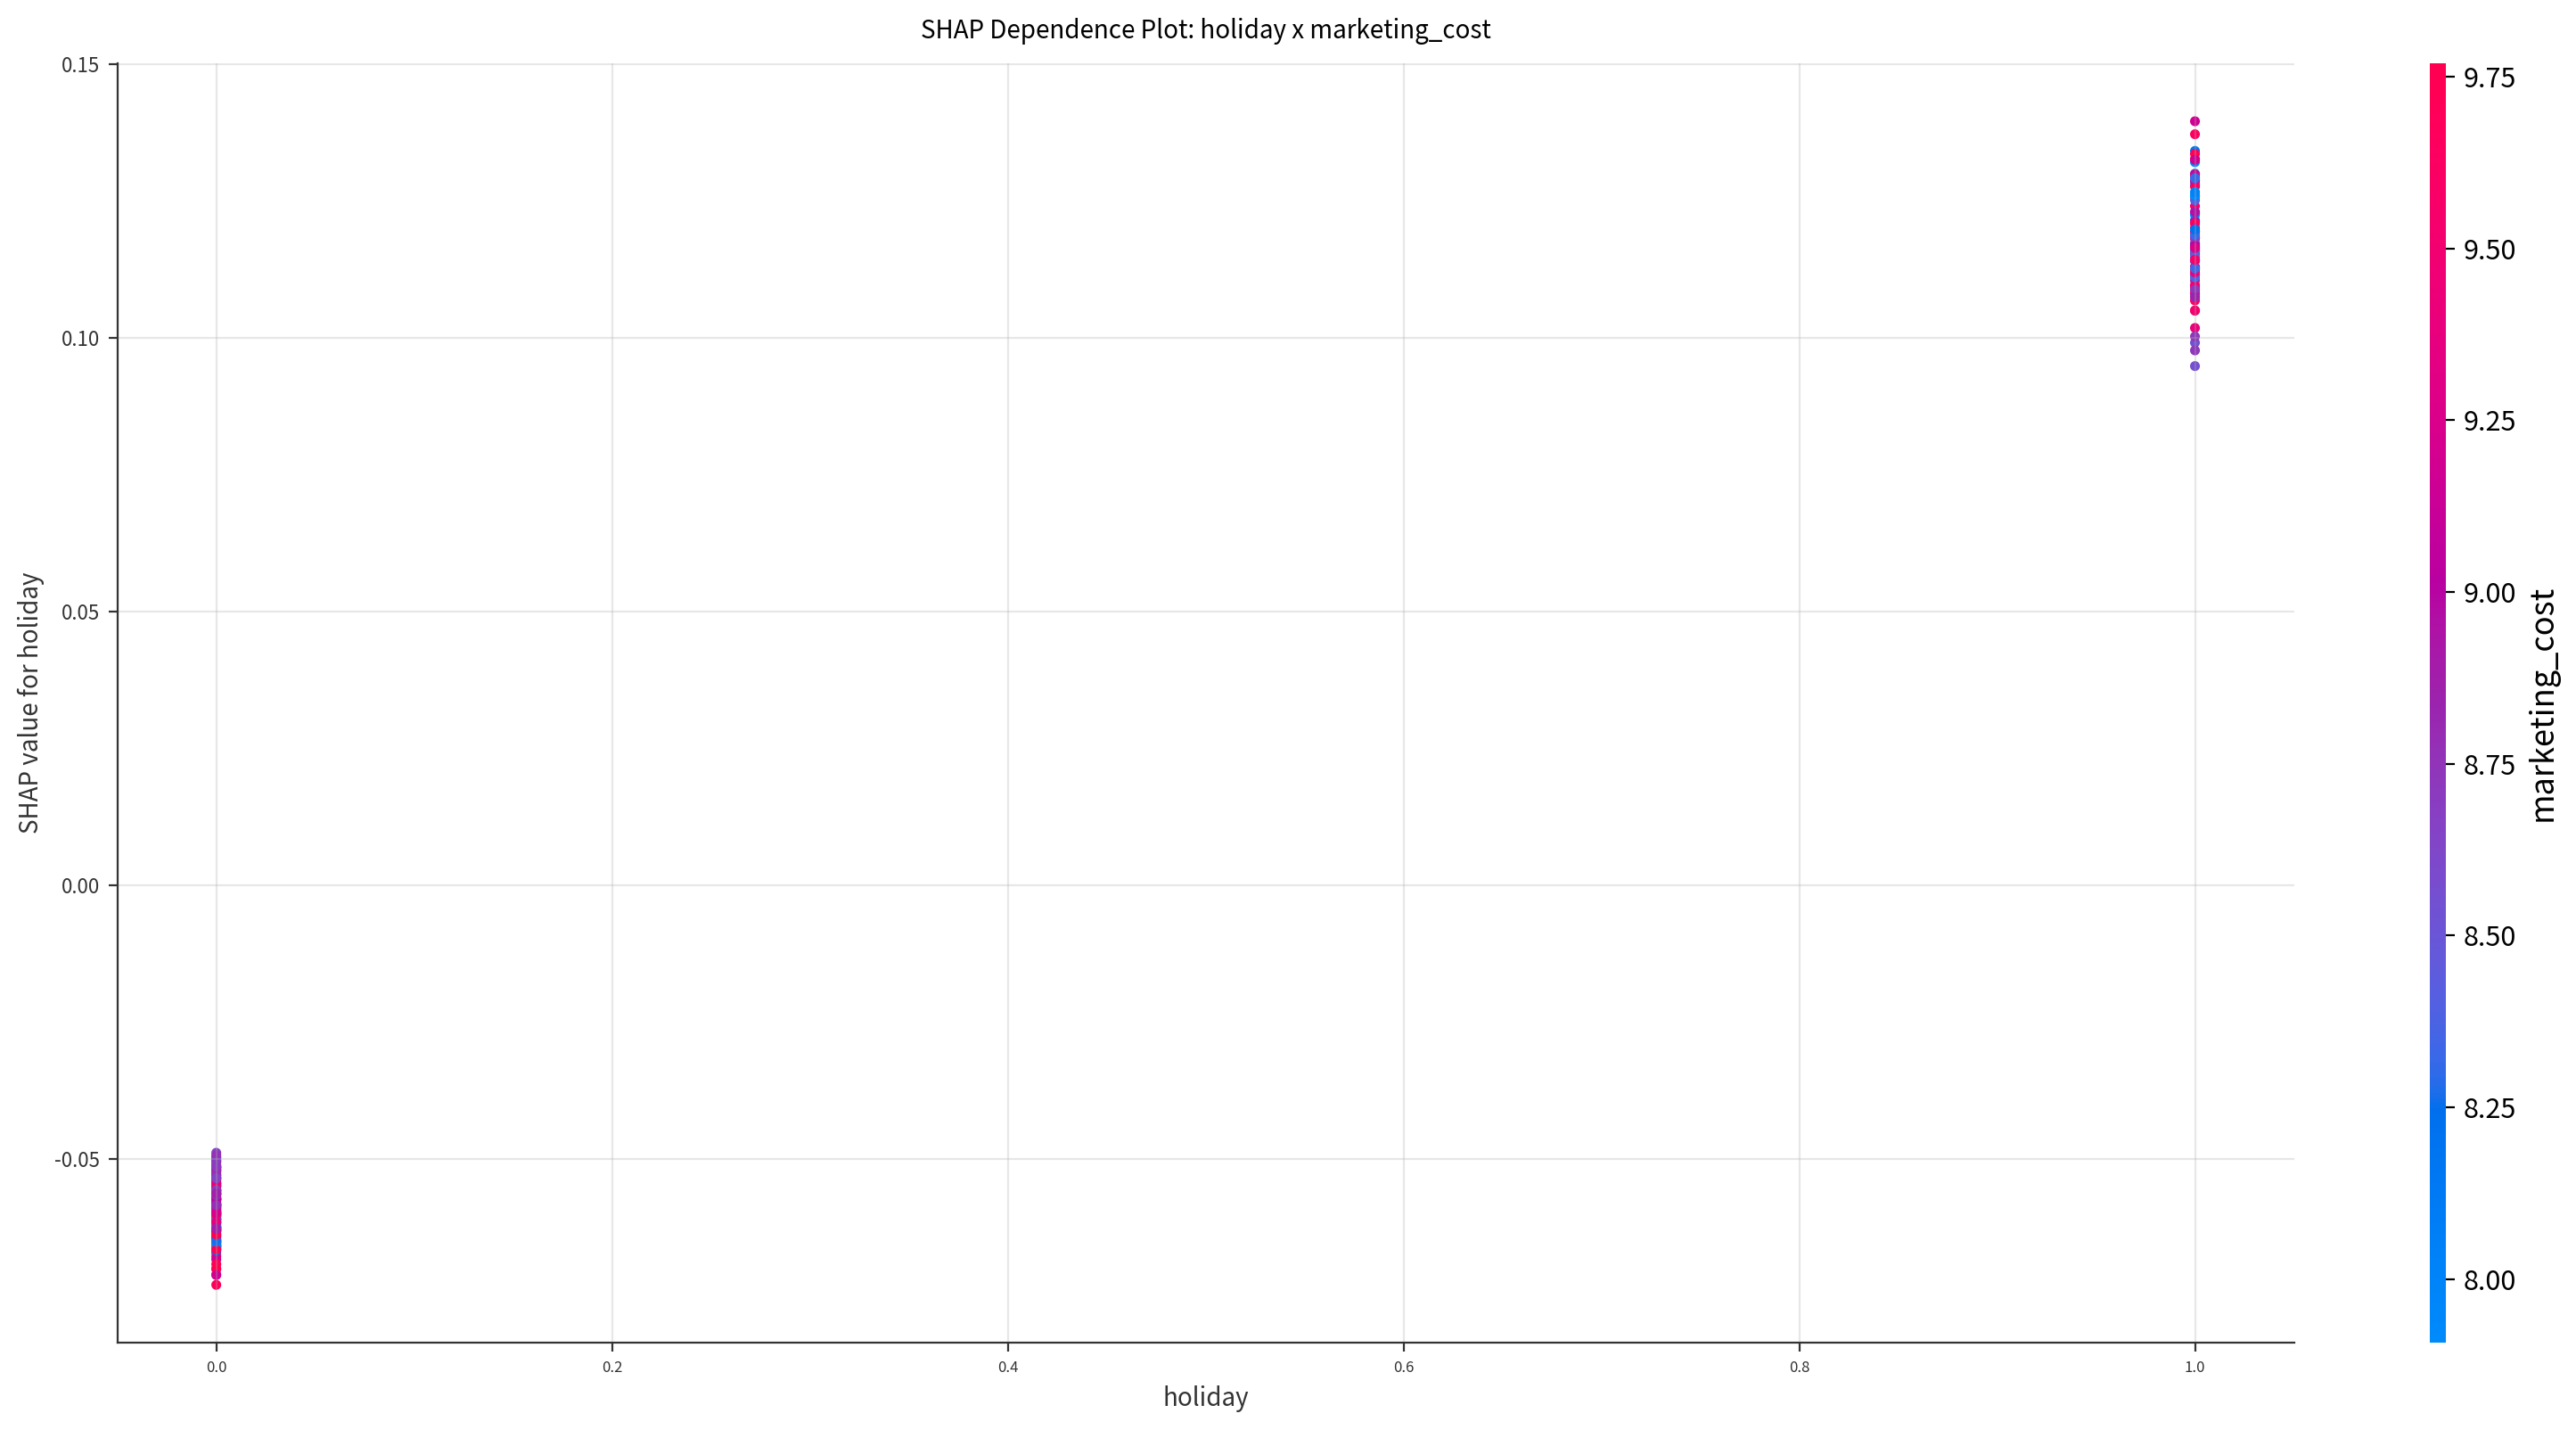

[('weekend', 'marketing_cost'),
 ('weekend', 'holiday'),
 ('marketing_cost', 'weekend'),
 ('marketing_cost', 'holiday'),
 ('holiday', 'weekend'),
 ('holiday', 'marketing_cost')]

In [9]:
hs_shap_dependence_analysis(summary_df, shap_values, x_train, include_secondary=False)